In [1]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import logging


In [2]:
# Set up logging to handle any corrupted images that may be encountered
logging.basicConfig(level=logging.INFO, filename='corrupted_images.log', filemode='w')
logger = logging.getLogger()

# Function to safely load and apply image processing
def load_image_safe(filepath, apply_processing=None):
    try:
        img = Image.open(filepath)
        img.verify()
        img = Image.open(filepath)
        
        # Apply processing if specified
        if apply_processing == "contrast":
            img = ImageEnhance.Contrast(img).enhance(1.5)  # Adjust contrast
        elif apply_processing == "blur":
            img = img.filter(ImageFilter.GaussianBlur(1))  # Apply Gaussian blur
        elif apply_processing == "edge":
            img = img.filter(ImageFilter.EDGE_ENHANCE)     # Enhance edges
            
        img = img.resize((224, 224))
        img = np.array(img) / 255.0
        return img
    except (IOError, SyntaxError) as e:
        logger.info(f"Corrupted image skipped: {filepath} | Error: {e}")
        return None


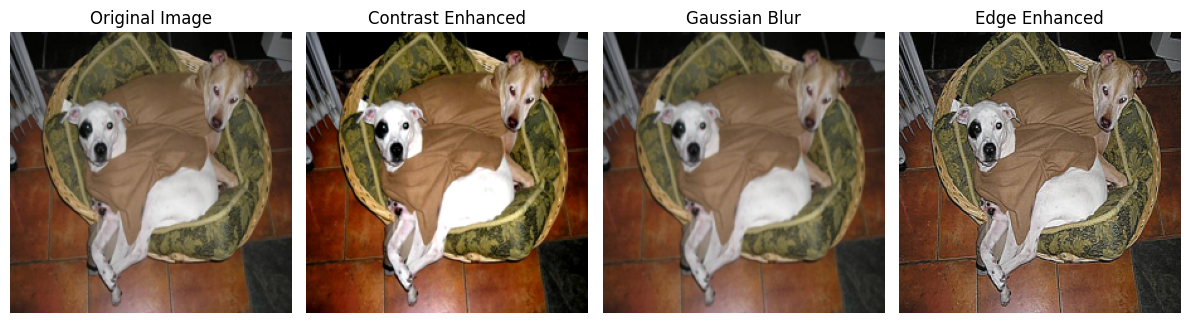

In [3]:
# Load a sample image from the "Dog" category
sample_directory = 'C:/Users/asus/Downloads/archive/kagglecatsanddogs_3367a/PetImages/Dog/'
sample_image_path = os.path.join(sample_directory, os.listdir(sample_directory)[9985])

# Apply different processing techniques
original_img = load_image_safe(sample_image_path)
contrast_img = load_image_safe(sample_image_path, apply_processing="contrast")
blurred_img = load_image_safe(sample_image_path, apply_processing="blur")
edge_img = load_image_safe(sample_image_path, apply_processing="edge")

# Plot all images side by side for comparison
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Contrast-enhanced Image
plt.subplot(1, 4, 2)
plt.imshow(contrast_img)
plt.title("Contrast Enhanced")
plt.axis('off')

# Gaussian-blurred Image
plt.subplot(1, 4, 3)
plt.imshow(blurred_img)
plt.title("Gaussian Blur")
plt.axis('off')

# Edge-enhanced Image
plt.subplot(1, 4, 4)
plt.imshow(edge_img)
plt.title("Edge Enhanced")
plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
def safe_image_generator(directory, image_size=(224, 224), batch_size=32, class_mode='binary', apply_processing=None):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True
    )

    while True:
        batch_data, batch_labels = generator.next()
        valid_images = []
        valid_labels = []
        for i in range(len(batch_data)):
            img_path = generator.filepaths[generator.index_array[i]]
            img = load_image_safe(img_path, apply_processing)
            
            # Ensure the image has the expected shape of (224, 224, 3)
            if img is not None and img.shape == (224, 224, 3):
                valid_images.append(img)
                valid_labels.append(batch_labels[i])
                
        if valid_images:
            yield np.array(valid_images), np.array(valid_labels)


In [12]:
def define_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:
def train_and_evaluate(directory_path, apply_processing=None):
    # Set up data generator with specified processing
    data_gen = safe_image_generator(
        directory=directory_path, 
        image_size=(224, 224), 
        batch_size=32, 
        class_mode='binary', 
        apply_processing=apply_processing
    )

    # Initialize and train the model
    model = define_model()
    history = model.fit(data_gen, steps_per_epoch=100, epochs=5)
    return history.history['accuracy'][-1]  # Return final accuracy


In [14]:
# Directory containing "Dog" and "Cat" subdirectories
directory_path = 'C:/Users/asus/Downloads/archive/kagglecatsanddogs_3367a/PetImages/'


In [8]:
# Training with original images
print("Training with original images...")
accuracy_original = train_and_evaluate(directory_path, apply_processing=None)
print("Accuracy with original images:", accuracy_original)


Training with original images...
Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 106s 1s/step - loss: 0.7737 - accuracy: 0.5097
Epoch 2/5
100/100 [==============================] - 109s 1s/step - loss: 0.6931 - accuracy: 0.5059
Epoch 3/5
100/100 [==============================] - 111s 1s/step - loss: 0.6932 - accuracy: 0.5028
Epoch 4/5
100/100 [==============================] - 115s 1s/step - loss: 0.6933 - accuracy: 0.5075
Epoch 5/5
100/100 [==============================] - 119s 1s/step - loss: 0.6934 - accuracy: 0.4913
Accuracy with original images: 0.49125000834465027


In [9]:
# Training with contrast-enhanced images
print("Training with contrast-enhanced images...")
accuracy_contrast = train_and_evaluate(directory_path, apply_processing="contrast")
print("Accuracy with contrast-enhanced images:", accuracy_contrast)

Training with contrast-enhanced images...
Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 117s 1s/step - loss: 1.1576 - accuracy: 0.4969
Epoch 2/5
100/100 [==============================] - 107s 1s/step - loss: 0.6932 - accuracy: 0.4931
Epoch 3/5
100/100 [==============================] - 106s 1s/step - loss: 0.6933 - accuracy: 0.4956
Epoch 4/5
100/100 [==============================] - 106s 1s/step - loss: 0.6931 - accuracy: 0.5078
Epoch 5/5
 65/100 [==================>...........] - ETA: 37s - loss: 0.6933 - accuracy: 0.4889

c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 106s 1s/step - loss: 0.6933 - accuracy: 0.4878
Accuracy with contrast-enhanced images: 0.48781248927116394


In [15]:
# Training with Gaussian-blurred images
print("Training with Gaussian-blurred images...")
accuracy_blur = train_and_evaluate(directory_path, apply_processing="blur")
print("Accuracy with Gaussian-blurred images:", accuracy_blur)


Training with Gaussian-blurred images...
Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 130s 1s/step - loss: 0.9711 - accuracy: 0.4809
Epoch 2/5
100/100 [==============================] - 125s 1s/step - loss: 0.6932 - accuracy: 0.5131
Epoch 3/5
100/100 [==============================] - 125s 1s/step - loss: 0.6933 - accuracy: 0.5009
Epoch 4/5
100/100 [==============================] - 127s 1s/step - loss: 0.6933 - accuracy: 0.5119
Epoch 5/5
100/100 [==============================] - 125s 1s/step - loss: 0.6935 - accuracy: 0.4891
Accuracy with Gaussian-blurred images: 0.48906248807907104


In [16]:
# Training with edge-enhanced images
print("Training with edge-enhanced images...")
accuracy_edge = train_and_evaluate(directory_path, apply_processing="edge")
print("Accuracy with edge-enhanced images:", accuracy_edge)


Training with edge-enhanced images...
Found 24959 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 106s 1s/step - loss: 0.8362 - accuracy: 0.5144
Epoch 2/5
100/100 [==============================] - 104s 1s/step - loss: 0.6934 - accuracy: 0.5019
Epoch 3/5
100/100 [==============================] - 104s 1s/step - loss: 0.6932 - accuracy: 0.5038
Epoch 4/5
100/100 [==============================] - 104s 1s/step - loss: 0.6934 - accuracy: 0.4897
Epoch 5/5
100/100 [==============================] - 105s 1s/step - loss: 0.6931 - accuracy: 0.5072
Accuracy with edge-enhanced images: 0.5071874856948853


In [17]:
print("Accuracy with original images:", accuracy_original)
print("Accuracy with contrast-enhanced images:", accuracy_contrast)
print("Accuracy with Gaussian-blurred images:", accuracy_blur)
print("Accuracy with edge-enhanced images:", accuracy_edge)

Accuracy with original images: 0.49125000834465027
Accuracy with contrast-enhanced images: 0.48781248927116394
Accuracy with Gaussian-blurred images: 0.48906248807907104
Accuracy with edge-enhanced images: 0.5071874856948853
